In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
     

In [2]:
data=pd.read_csv('mnist_train.csv')


In [3]:
rand=np.random.randint(0,data.shape[0],10000)
data=data.iloc[rand,:].reset_index()
data.drop(columns='index',inplace=True)
data

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0         7    0    0    0    0    0    0    0    0    0  ...      0      0   
1         6    0    0    0    0    0    0    0    0    0  ...      0      0   
2         9    0    0    0    0    0    0    0    0    0  ...      0      0   
3         2    0    0    0    0    0    0    0    0    0  ...      0      0   
4         6    0    0    0    0    0    0    0    0    0  ...      0      0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
9995      5    0    0    0    0    0    0    0    0    0  ...      0      0   
9996      9    0    0    0    0    0    0    0    0    0  ...      0      0   
9997      6    0    0    0    0    0    0    0    0    0  ...      0      0   
9998      8    0    0    0    0    0    0    0    0    0  ...      0      0   
9999      3    0    0    0    0    0    0    0    0    0  ...      0      0   

      28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0         0      0      0      0      0      0      0      0  
1         0      0      0      0      0      0      0      0  
2         0      0      0      0      0      0      0      0  
3         0      0      0      0      0      0      0      0  
4         0      0      0      0      0      0      0      0  
...     ...    ...    ...    ...    ...    ...    ...    ...  
9995      0      0      0      0      0      0      0      0  
9996      0      0      0      0      0      0      0      0  
9997      0      0      0      0      0      0      0      0  
9998      0      0      0      0      0      0      0      0  
9999      0      0      0      0      0      0      0      0  

[10000 rows x 785 columns]

In [4]:
labels=data.iloc[:,0]
data=data.drop(columns='label',axis=1)
print(labels.shape)
print(data.shape)

(10000,)
(10000, 784)


In [5]:
dataNorm = data/np.max(data)



In [7]:
dataT   = torch.tensor( dataNorm.values ).float()
labelsT = torch.tensor( labels ).long()

where7=labels==7
dataNo7=dataT[~where7,:]
labelsNo7=labelsT[~where7]
data7=dataT[where7,:]


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(dataNo7,labelsNo7)
test_data  = TensorDataset(data7)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     

In [8]:
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [9]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

              ### input layer
            self.input = nn.Linear(784,64)

              ### hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

              ### output layer
            self.output = nn.Linear(32,10)

    # forward pass
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )
            return torch.log_softmax( self.output(x),axis=1)
          # NOTE: log-softmax the output (b/c loss function)

  # create the model instance
    net = mnistNet()
  
  # loss function
    lossfun = nn.NLLLoss()

  # optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01)

    return net,lossfun,optimizer
     


In [11]:
def function2trainTheModel():

      # number of epochs
    numepochs = 100

      # create a new model
    net,lossfun,optimizer = createTheMNISTNet()

      # initialize losses
    trainlosses = np.zeros(numepochs)
    trainAcc  = []


      # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

          # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # loss from this batch
            batchLoss.append(loss.item())

          # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        trainlosses[epochi] = np.mean(batchLoss)

      # end epochs
    return trainAcc,trainlosses,net


In [12]:
trainAcc,trainlosses,net=function2trainTheModel()


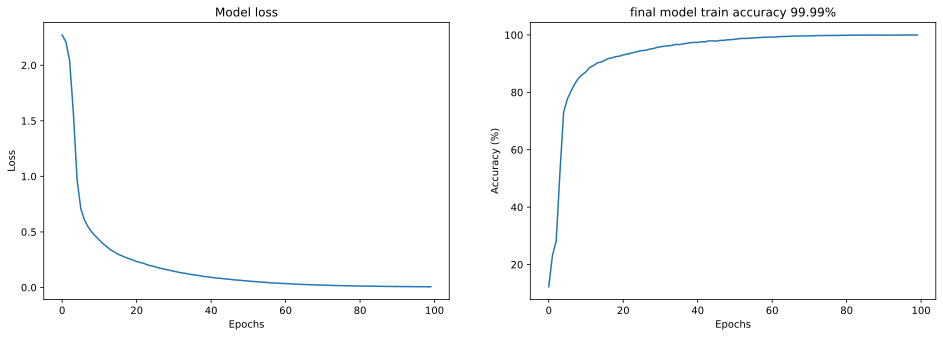

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainlosses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train normalized')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'final model train accuracy {trainAcc[-1]:.2f}%')

plt.show()
     

In [20]:
X=next(iter(test_loader))[0]
preds=net(X).detach()
guesses=torch.argmax(preds,axis=1).detach()

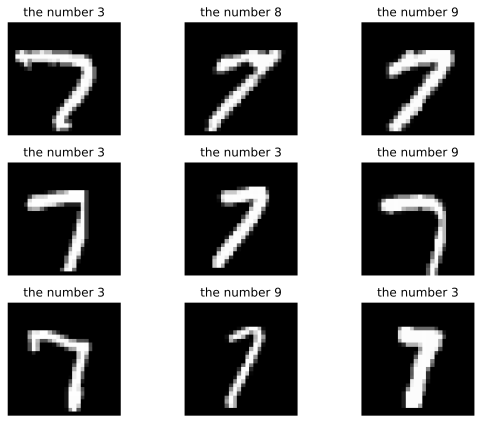

In [25]:
fig,axs=plt.subplots(3,3,figsize=(8,6))
somerandom7s=np.random.choice(len(X),9)
for i,ax in enumerate(axs.flatten()):
    thisimg=X[somerandom7s[i]].view(28,28)
    ax.imshow(thisimg,cmap='gray')
    ax.set_title(f'the number {guesses[somerandom7s[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
print(np.unique(guesses))


[0 1 2 3 4 5 6 8 9]


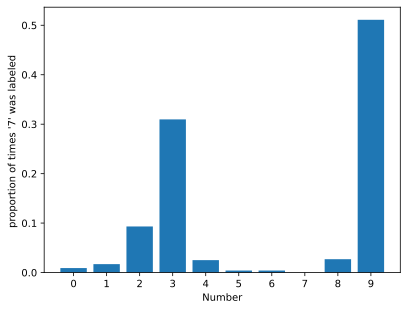

In [27]:
probMistaken=np.zeros(10)
for i in range(10):
    probMistaken[i]=torch.mean((guesses==i).float())
plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel("proportion of times '7' was labeled ")
plt.show()

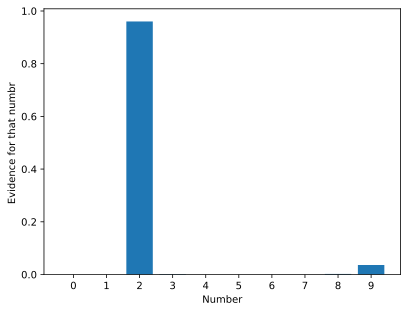

In [31]:
smaple2show=71
plt.bar(range(10),torch.exp(preds[smaple2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel("Evidence for that numbr ")
plt.show()